# Computing statistics from trajectories

## Goal of the notebook

The goal of the notebook is to analyze the statistice of the performance of the Benchmakr. Please run cell after cell and follow the instructions.
In the end of this notebook, you will get a .yaml file that includes information about:
 * the mean of the offset (distance and angle) of the Duckiebot in respect to the center of the lane
 * The number of rounds completed (entirely completed by the center of the April Tag placed on the localization standoff on your Duckiebot
 * The number of tile covered (center of April Tag coompletely passed the tile)
 * Avg time needed per tile in seconds
 * Length of the Benchmark in seconds
 * Actual length of the benchmark in seconds
 * Mean offset measured by Watchtowers (ground truth)
 * Std of the offset measured by Watchtowers (ground truth)
 * Mean angle measured by Watchtowers (ground truth)
 * Std of the angle measured by Watchtowers (ground truth)
 * Mean offset measured by the Duckiebot
 * Std of the offset measured by the Duckiebot
 * Mean angle measured by the Duckiebot
 * Std of the angle measured by the Duckiebot
 * Mean of the difference between offset measured by the Duckiebot and by the Watchtowers (ground truth)
 * Std of the difference between offset measured by the Duckiebot and by the Watchtowers (ground truth)
 * Mean of the difference between the angle measured by the Duckiebot and by the Watchtowers (ground truth)
 * Std of the difference between the angle measured by the Duckiebot and by the Watchtowers (ground truth)
 
 
 Please note that a offset calculated by the Watchtowers that is positive, means that the Duckiebot drives more on the right side of the lane.
 The same is valid for the db_offset estimation (a positive estimation means he stands a bit to the right of the lane)

As you run this notebook for each test_run you did of the specific Benchmark, please change below the variable `test_run` to the number of test_run you are currently running the notebook with.
(Ex. test_run = '01' or test_run = '12' etc)

In [21]:
test_run = ''

In [22]:
#!/usr/bin/env python
# coding: utf-8

import contracts
contracts.disable_all()

import geometry as geo
import math 
import numpy as np
from os import path, listdir
from scipy import stats
import yaml

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world import draw_static


# import geometry_msgs
# import geometry_msgs.msg
# import geometry_msgs.msg._TransformStamped
# import geometry_msgs.msg._TransformStamped as TransformStamped

Please change the Map_Name below if you ran your Benchmark on a different map than `linus_loop`

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/139670823158840/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/139670823158840/drawing.html


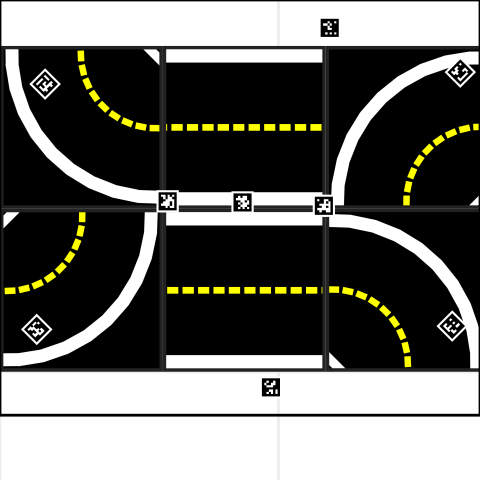

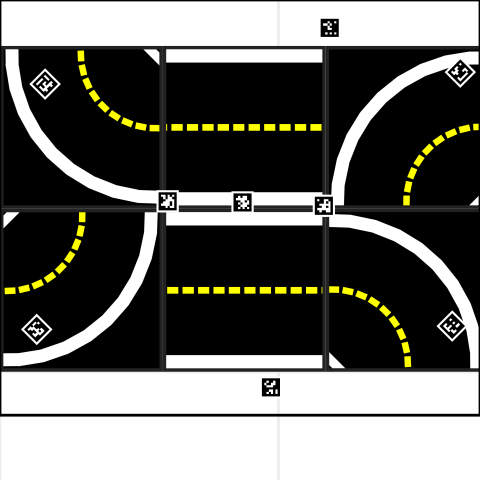

In [23]:
Map_Name = 'linus_loop'

m = dw.load_map(Map_Name)

ipython_draw_svg(m)

Below we prepare all kinds of different lists in which the data read from the files will be saved.

In [24]:
offset_db = []
offset_wt_interp=[]
offset_wt_mine_1 = []
offset_wt_non_interp = []
time_db = []
time_wt = []
time_wt_mine =[]
offset_wt_x = []
offset_wt_y = []
angle_db = []
angle_wt_interp = []
angle_wt_mine_1 = []
angle_wt_non_interp = []

last_seen_idx = []
last_index_slow = []
time_lasted = []
time_lasted_slow = []
total_length_bag = []

actual_length = []
actual_length_indx = []

time_rel_db = []
d_rel_db = []
phi_rel_db = []

all_traj_save = []
all_traj_db_save = []
int_trajs_save = []


Below the stopping conditions of the Lane Following Benchmark are defined.
At the moment the Benchmark is stopped if the Duckiebot is out of sight of the watchtowers for longer than 3 seconds or if the Duckiebot crashes respectively takes more than 30 seconds to get across one single tile.

If you think that the time, the Duckiebot needs to be out of sight such that the Benchmark is stoped, needs to be different from 3 seconds, please change the variable `tolerance_out_of_sight`.

Also if you think that the "crash" condition is not right please change the variable `max_time_on_tile`

Also the theoretical lenght of the bag recorded could be changed below.

Please not that if you change these variables you the change the benchmark results. This is why it is necessary to leave the constants at the suggested values such that you can compare your Benchmark with others later.



In [25]:
tolerance_out_of_sight = 3.0
max_time_on_tile = 15.0

theoretical_length = 50.0

## Some utilities that we are going to use later

In [26]:
class AFakeBar(dw.PlacedObject):
    "Ellipse object with a large ration between the radii"

    def __init__(self, len=0, fill_opacity=0.5, color='pink', *args, **kwargs):
        self.len = len
        self.fill_opacity = fill_opacity
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.ellipse(center=(0, 0), r=(0.03,self.len), fill=self.color, fill_opacity=self.fill_opacity)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)
        

class Circle(dw.PlacedObject):
    "Circle object."

    def __init__(self, radius, color='pink', *args, **kwargs):
        self.radius = radius
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.circle(center=(0, 0), r=self.radius, fill=self.color)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)

    def extent_points(self):
        # set of points describing the boundary
        L = self.radius
        return [(-L, -L), (+L, +L)]


def relative_pose(q0, q1):
    "Computes the relative pose between two points in SE2"
    return geo.SE2.multiply(geo.SE2.inverse(q0), q1)


def interpolate(q0, q1, alpha):
    "Interpolates between two points in SE2, given a coefficient alpha."
    q1_from_q0 = relative_pose(q0, q1)
    vel = geo.SE2.algebra_from_group(q1_from_q0)
    rel = geo.SE2.group_from_algebra(vel * alpha)
    q = geo.SE2.multiply(q0, rel)
    return q

def find_nearest(array, value):
    """Finds the index within the array for which the entry is closest to value"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_trajectory(localization_log):
    "From a log file from the localization system, extract a list of transforms describing the trajectory \
    measured by the watchtowers."

    final_trajectory = []
    begin_time_stamp_wt = localization_log['begin_time_stamp']
    len_trajectory = len(localization_log['trajectory_data'])
    x, y = np.zeros(len_trajectory), np.zeros(len_trajectory)
    R = np.zeros((3, 3, len_trajectory))
    phi = np.zeros((3, len_trajectory))
    prev_time_stamp = 0.0
    i =0
    out_of_sight = False
    
    total_length_bag.append(float((sorted(localization_log['trajectory_data'].keys()))[-1]))
    actual_length.append(float((sorted(localization_log['trajectory_data'].keys()))[-1]))
    actual_length_indx.append(len_trajectory)
    
    for i, (time, traj) in enumerate(localization_log['trajectory_data'].items()):
        # Checks if the Duckiebot has been out of sight for more than `tolerance_out_of_sight` (= 3) seconds 
        # if it was, the trajectory extraction is stopped and the time when the Duckiebot was last seen by the 
        # watchtowers is saved. Also it saves the index when it was last seen and shortens the trajectory to this 
        # length as benchmark must stop there!
        if ((float(time) - float(prev_time_stamp) >= tolerance_out_of_sight) and (i != 0)):
            time_lasted.append(float("{:.4f}".format(float(prev_time_stamp))))
            actual_length[0] = (float("{:.4f}".format(float(prev_time_stamp))))
            last_seen_idx.append(i-1)
            actual_length_indx[0] = i-1
            out_of_sight = True
            break
            
        # Computes the different values for (x,y) position, the rotation matrix as well as the angle phi at each time
        # stamp 
        time_wt.append(time)
        prev_time_stamp = float("{:.4f}".format(float(time)))
        x[i] = np.array(float("{:.4f}".format(float(traj[0]))))
        y[i] = np.array(float("{:.4f}".format(float(traj[1]))))
        offset_wt_x.append(x[i])
        offset_wt_y.append(y[i])
        R[:, :, i] = np.reshape(np.array(traj[3:]), (3, 3))
        phi[:, i] = np.array([np.arctan2(-R[1, 2, i], R[2, 2, i]),
                              np.arctan2(R[0, 2, i], np.sqrt(R[0, 0, i] ** 2 + R[0, 1, i] ** 2)),
                              np.arctan2(-R[0, 1, i], R[0, 0, i])])

        z = float("{:.4f}".format(phi[2, i]))
        points = np.array([x[i], y[i]])
        final_trajectory.append([points, z])
        
    final_array = final_trajectory.copy()

    # transforms trajectory from the translation_angle into SE2
    traj_tfs = []
    
    for entry in range(0, len(final_array)):
        x, y = final_array[entry][0][0:2]
        theta = final_array[entry][1]
        q = geo.SE2_from_translation_angle([x, y], theta)
        q_test = geo.SE2_from_translation_angle([x.item(), y.item()], theta)
        traj_tfs.append(q)
        all_traj_save.append(q_test.tolist())
    
    return traj_tfs, out_of_sight, begin_time_stamp_wt


def extract_offset_db(localization_log, begin_time_stamp_wt):
    "From a log file from the Duckiebot, extract the information of the calculated offset and angle by the Duckiebot."

    final_trajectory = []
    
    # compares the to beginning time_stamps to take into account slight offset between the bag recordings
    begin_time_stamp_db_post = localization_log['begin_time_stamp']
    diff_btw_time_stamps_dbpost_wt = float("{:.4f}".format((begin_time_stamp_db_post - begin_time_stamp_wt)))
#     print(diff_btw_time_stamps_dbpost_wt)
    len_trajectory = len(localization_log['odometry_data'])
    x = np.zeros(len_trajectory)
    Q = np.zeros((4, len_trajectory))
    theta = np.zeros(len_trajectory)
    phi = np.zeros( len_trajectory)

    # extracts the offset which is given in meters as well as the quaternion describing the rotation
    # the quaternion then is transformed into the angle using the fact that phi = arctan(2*Q2*Q3/(1-2*Q2^2)) 
    # according to https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
    
    for i, (time, traj) in enumerate(localization_log['odometry_data'].items()):
        if float(time) + diff_btw_time_stamps_dbpost_wt > float(time_wt[-1]):
            break
        x[i] = np.array(float("{:.4f}".format(float(traj[0]))))
        offset_db.append(x[i].item())
        Q[:, i] = np.array(traj[3:])
        phi[i] = math.atan2((2*Q[2,i]*Q[3,i]),(1 - 2*Q[2,i]*Q[2,i]))
        #Or simply reverse the calculation done within the post_processor
        #phi[i] = math.pi - math.asin(Q[3,i])*2
        time_db.append(str(np.round((float(time) + diff_btw_time_stamps_dbpost_wt),6)))
        z = float("{:.4f}".format(phi[i]))
        angle_db.append(z)
        points = x[i]
        all_traj_db_save.append([points.item(), z])
        final_trajectory.append([points, z])
        
    final_array = final_trajectory.copy()
    

    return final_array


def get_interpolated_points(center_line, trajectories):
    """Generates an interpolated point for each point on the center line, for each trajectory as long as the point
    lies between two trajectory points."""
    
    # ToDo if time, check if the interpolated points can be used for further calculations
    closest_behind = [None] * len(trajectories)
    interpolated_trajectories = []
    for center_point in center_line:
        interpolated_points = []
        interpolated_points_test = []
        for idx_t, traj in enumerate(trajectories):
            interpolated_point_traj = None
            begin_t = closest_behind[idx_t] if closest_behind[idx_t] else 0
            for idx_point in range(begin_t, len(traj)):
                if a_behind_b(a=traj[idx_point], b=center_point):
                    closest_behind[idx_t] = idx_point
                    continue

                if closest_behind[idx_t] is None:
                    # If there is no point behind we cannot compute the interpolation
                    interpolated_point_traj = None
                    break
                else:
                    try:
                        interpolated_point_traj = interpolate_magic(center_point,
                                                                    traj[closest_behind[idx_t]],
                                                                    traj[closest_behind[idx_t] + 1])
                        break

                    except IndexError:
                        print('The index is outside the list!')
                        interpolated_point_traj = None
                        break
            interpolated_points.append(interpolated_point_traj)
            try:
                interpolated_points_test.append(interpolated_point_traj.tolist())
            except:
                interpolated_points_test.append(interpolated_point_traj)
        interpolated_trajectories.append(interpolated_points)
        int_trajs_save.append(interpolated_points_test)
    return interpolated_trajectories


def a_behind_b(a=None, b=None):
    """Check if a is behind b wrt the heading direction of a."""
    if a is None or b is None:
        return False
    rel_pose = relative_pose(b, a)
    return dw.SE2Transform.from_SE2(rel_pose).p[0] < 0


def interpolate_magic(center_pt, previous_pt, next_pt):
    """Returns an interpolated point between previoust_pt and next_pt at the height of center_pt"""
    tf_prev = relative_pose(center_pt, previous_pt)
    d_prev = dw.SE2Transform.from_SE2(tf_prev).p[0]

    tf_next = relative_pose(center_pt, next_pt)
    d_next = dw.SE2Transform.from_SE2(tf_next).p[0]

    alpha = np.abs(d_prev) / (np.abs(d_prev) + d_next)
    interpolated_pt = interpolate(previous_pt, next_pt, alpha)
    return interpolated_pt


def get_used_lanes(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    """It also calculates the number of completed laps, the time needed per tile and it counts the number"""
    """of tiles covered (total as well as specific for different types)"""
    """Moreover it checks if the Duckiebot had a crash or drives too slow -> if the center of the April Tag"""
    """of the  Duckiebot takes more than 30 seconds to get across one tile the Benchmark is stoped there"""
    """The time when this happened is saved and the trajectories are shorten to that time"""
    
    # If in future for another Benchmark there are other tiles part of the loop just add a dictionary for them as well
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()
    last_lane_seg = dict()
    prev_lane_seg = ()
    current_lane_seg = ()
    start_tile = ()
    
    total_nb_of_tiles = 0
    nb_straight_tiles = 0
    nb_curve_left = 0
    nb_curve_right = 0
    nb_complete_laps = 0
    
    too_slow = False
    
    first_time_on_tile = 0.0
    start = False
    new_tile = False
    count = 0
    
    
    for traj in trajectories:
        for pose in traj:
            count += 1
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn
                if not start:
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                    
                    start_tile = lane_segment_name
                    current_lane_seg = lane_segment_name
                    prev_lane_seg = lane_segment_name
                    first_time_on_tile = float(time_wt[count])
                    start = True
                    
                if lane_segment_name[1] == current_lane_seg[1]:
                    new_tile = False
                    # the following condoition checks if the Duckiebot drives too slow or not
                    if abs(float(first_time_on_tile) - float(time_wt[count])) > max_time_on_tile:
                        last_index_slow.append(count)
                        time_lasted_slow.append(float(time_wt[count]))
                        print("DB too slow")
                        too_slow = True
                        break
                elif lane_segment_name[1] != current_lane_seg[1]:
                    new_tile = True
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                    first_time_on_tile = float(time_wt[count])
                    current_lane_seg = lane_segment_name
                    
                    if lane_segment_name[1] == start_tile[1]:
                        print("new round")
                        nb_complete_laps +=1
                
                #checks if the lane segment appears for the first time or not
                #if it appears for the first time the new lane segment is added to the list of used lane segments
                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass

    return used_lane_segs_list, lane_segs_tfs, nb_complete_laps, too_slow, total_nb_of_tiles, \
    nb_straight_tiles, nb_curve_left, nb_curve_right


def get_global_center_line(map, used_lane_segs, global_segs_SE2, pts_per_segment, length):
    "Builds a center line for all the used lanes in the global coordinate frame."
    center_line = []
    center_line_global = []
    center_line_global_tfs = []
    
    # The number of points genereated for the center line depends on the tile 
    # mid is the number of points for a straight tile
    # long is the number of points for a left curve tile
    # short is the number of points for a right curve tile
    for i, lane_segment in enumerate(used_lane_segs):
        if lane_segment[2] == 'straight':
            n_inter = int(pts_per_segment['mid'])
        elif lane_segment[-1] == 'lane2':
            n_inter = int(pts_per_segment['long'])
        elif lane_segment[-1] == 'lane1':
            n_inter = int(pts_per_segment['short'])
        lane = map[lane_segment]

        # The end point is part of next tile
        steps = np.linspace(0, len(lane.control_points) - 1, num=n_inter, endpoint=False)

        for beta in steps:
            center_point_local_SE2 = lane.center_point(beta)
            center_line.append(center_point_local_SE2)

            # get SE2 of the point in global coords
            center_point_global_SE2 = geo.SE2.multiply(global_segs_SE2[lane_segment],
                                                       center_point_local_SE2)

            center_line_global.append(center_point_global_SE2)
            center_line_global_tfs.append(dw.SE2Transform.from_SE2(center_point_global_SE2))

    
    
    return center_line_global, center_line_global_tfs

def get_trajectories_statistics(trajectories, center_line):
    """Computes mean trajectory and std deviations for y and angle given a list of trajectories sampled at the same x"""
    mean_tfs = []
    std_y = []
    std_heading = []

    start_idx = None
    end_idx = None
    # We need to find the first amd last index for which all trajectories have a point
    for idx, trajs_points in enumerate(trajectories):
        if all(trajs_points) and start_idx is None:
            start_idx = idx
        elif not all(trajs_points) and start_idx is not None:
            end_idx = idx
            break
    end_idx = -1 if end_idx is None else end_idx
    complete_trajectories = trajectories[start_idx:end_idx]

    for tfs, tfs_center in zip(complete_trajectories,center_line):
        xs = [tf.p[0] for tf in tfs]
        ys = [tf.p[1] for tf in tfs]
        headings = [tf.theta for tf in tfs]
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        # To compute mean angles we need to pay attention
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_tfs.append(dw.SE2Transform.from_SE2(geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)))
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation = []
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)

        relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))

        lateral_deviation.append(float(np.round(relative_tf.p[1],6)))
        offset_wt_interp.append(float(np.round(relative_tf.p[1].item(),6)))
        angle_wt_interp.append(float(np.round(relative_tf.theta,6)))
        std_y.append(float(np.round(np.std(lateral_deviation),6)))
        std_heading.append(float(np.round(stats.circstd(headings, low=-math.pi, high=math.pi),6)))
        
    return mean_tfs, std_y, std_heading, start_idx, end_idx

def find_nearest_2d(mid_line, point, theta):
    """Function to find the nearest point on the midle line to a specific point in 2d"""
    """It then calculates the relative x and y offset of the point to the nearest point on the center line"""
    """ as well as the relative angle of the April Tag on your Duckiebot compared to the cener line"""
#     print(value)
    min_dist = 100000
    rel_offset_cr_min = 10000
#     print(type(mid_line))
    start = True
    indx = 0
    for i in range(1, len(mid_line)):
        xs_c = mid_line[i].p[0]
        ys_c = mid_line[i].p[1]
        xs_p = mid_line[i-1].p[0]
        ys_p = mid_line[i-1].p[1]
        p1 = np.array([xs_p,ys_p])
        p2 = np.array([xs_c,ys_c])
        p3 = np.array([point[0],point[1]])
        rel_offset_cr = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
        if rel_offset_cr < rel_offset_cr_min:
            rel_offset_cr_min = rel_offset_cr
            indx = i
        dist = (point[0]-xs_c)**2 + (point[1]-ys_c)**2
        if dist < min_dist:
            min_dist = dist
            
        
            
    rel_x = point[0] - mid_line[indx].p[0] 
    rel_y = point[1] - mid_line[indx].p[1] 
    rel_angle = mid_line[indx].theta
    theta_rel = np.arctan2(np.mean(np.sin(theta-rel_angle)),np.mean(np.cos(theta-rel_angle)))
    
#     indx = (mid_line.index(idx))    
    return indx, rel_x, rel_y, theta_rel, rel_offset_cr_min

def get_trajectories_statistics_not_int(trajectories, center_line):
    """For each point on the trajectory of the Duckiebot, the relative offset as well as its angle of the center of """
    """the April Tag of your Duckiebot is calculated"""
    mean_tfs = []
    std_y = []
    std_heading = []

    complete_trajectories = trajectories[:]
    lateral_deviation_tes = []
    rel_offset_cr = []
    theta_rel_cr = []
    
    for tfs in complete_trajectories:
        xs = [tf.p[0] for tf in tfs]
        ys = [tf.p[1] for tf in tfs]        
        headings = [tf.theta for tf in tfs]
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        
        relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))
        
        rel_offset_cr.append(rel_offset_cr_min)
        theta_rel_cr.append(theta_rel)
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation_tes.append((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))
#         print((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))

        #Another version of how to caluclate offset_wt
#         offset_wt_mine_1.append(float(np.round(rel_offset_cr_min.item(),6)))
#         angle_wt_mine_1.append(float(np.round(theta_rel.item(),6)))
        offset_wt_non_interp.append(float(np.round(relative_tf.p[1].item(),6)))
        angle_wt_non_interp.append(float(np.round(relative_tf.theta,6)))
    return lateral_deviation_tes

In [27]:
from os import path, listdir
import json
import yaml
import matplotlib.pyplot as plt
import numpy as np
# from scipy import interpolate

experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY')

## Loading data




Then we need to load the trajectories from the logs of the localization system. Therefor, we need to load the yaml file created by the graph-optimizer called `AutobotAPRILTAGNB.yaml` where APRILTAGNR is the number of the April Tag that is placeon top of your Duckiebot


In [28]:
experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY/yaml/graph_optimizer')

localization_logs = [path.join(logs_path, f) for f in listdir(logs_path) if path.isfile(path.join(logs_path, f))]
print(f'Logs found: {localization_logs}')

all_logs = []
for filename in localization_logs:
    with open(filename, 'r') as file:
        all_logs.append(yaml.safe_load(file))
        
# Load the evaluation map
m = dw.load_map(Map_Name)

# Get a list of the trajectory
all_trajectories = []
for log in all_logs:
    # this function extracts the trajectory up until the end if the Duckiebot was never out of sight for more than 
    # 3 sec
    ext_traj, out_of_sight, begin_time_stamp_wt = extract_trajectory(log)
    all_trajectories.append(ext_traj)
if not out_of_sight:
    last_seen_idx.append(actual_length_indx[0])
    time_lasted.append(actual_length[0])

# Evaluate the used lane and extract some interesting information out of it.
used_lane_segments_list, lane_segments_SE2, nb_complete_laps, too_slow, total_nb_of_tiles, \
nb_straight_tiles, nb_curve_left, nb_curve_right \
= get_used_lanes(all_trajectories)

# shortens the trajectory and everything if the Duckiebot was too slow or crashed
if too_slow:
    all_traj_save = all_traj_save[:last_index_slow[0]]
    all_trajectories[0] = all_trajectories[0][:last_index_slow[0]]
    time_wt = time_wt[:last_index_slow[0]]
    actual_length[0] = time_lasted_slow[0]
    actual_length_indx[0] = last_index_slow[0]
if not too_slow:
    last_index_slow.append(actual_length_indx[0])
    time_lasted_slow.append(actual_length[0])



Logs found: ['../data/BenchmarkXY/yaml/graph_optimizer/autobot18.yaml']


INFO:dt-world:loading map linus_loop


Load the .yaml file created by the post processor called `BAGNAME_db_estimation.yaml`

In [29]:
experiment_dir_db = ''

logs_path_db = path.join(experiment_dir_db, '../data/BenchmarkXY/yaml/post_processor')

localization_logs_db = [path.join(logs_path_db, f) for f in listdir(logs_path_db) if path.isfile(path.join(logs_path_db, f))]
print(f'Logs found: {localization_logs_db}')

all_logs_db = []
for filename_db in localization_logs_db:
    with open(filename_db, 'r') as file_db:
#         data = file.read()
        all_logs_db.append(yaml.safe_load(file_db))
    
# Load the evaluation map
m_db = dw.load_map('linus_loop')


# Extract the 2d position and the angle of the Duckiebot within the map
all_trajectories_db = []
for log_db in all_logs_db:
    all_trajectories_db.append(extract_offset_db(log_db, begin_time_stamp_wt))


Logs found: ['../data/BenchmarkXY/yaml/post_processor/user_test.yaml']


INFO:dt-world:loading map linus_loop


If you recorded a bag on the Duckiebot whilst running the experiment, please set the variable `recorded_db_bag` below to `True` and upload below the BAGNAME_lane_pose.json file.

If you did not that is fine, as the pose estimation of the Duckiebot has already been extracted from the `.yaml` file created by the post-processor.
In this case please set the variable `recorded_db_bag` below to `False` and ignore the upload button below. Also make sure you type in the BAGNAME (following the convention explained in the documentation) when you are asked to.

In [30]:
recorded_db_bag = False

In [31]:
if not recorded_db_bag:
    print("Please enter below the BAGNAME you have chosen for the recorings of the Bags whilst running the experiment")

Please enter below the BAGNAME you have chosen for the recorings of the Bags whilst running the experiment


In [32]:
BAGNAME = ''

if not recorded_db_bag:
    name = BAGNAME

In [33]:
from ipywidgets import FileUpload

lane_pose = FileUpload(accept='.json',
    multiple=False)
lane_pose

FileUpload(value={}, accept='.json', description='Upload')

Make sure to run the next cell after having uploaded the correct file

In [34]:
if recorded_db_bag:    
    assert lane_pose.data, 'File missing, please upload in above cell'
    data = json.loads(lane_pose.data[0].decode('utf-8'))
    dict_total_lat = {}

    # extracts BAGNAME
    name = next(iter(lane_pose.value))
    name = name.replace("_lane_pose.json","")

    begin_time_stamp_db_dir = data['time'][0]
    diff_btw_time_stamps_dbdir_wt = float("{:.4f}".format((begin_time_stamp_db_dir - begin_time_stamp_wt)))
#     print(diff_btw_time_stamps_dbdir_wt)



    # all the data calculated directly by the Duckiebot is extracted which are: timestamp, offset and angle
    for i in range(0,len(data['phi'])):
        if data['time_rel'][i] + diff_btw_time_stamps_dbdir_wt > float(time_wt[-1]):
            break
        time_rel_db.append(float((data['time_rel'][i] + diff_btw_time_stamps_dbdir_wt)))
        d_rel_db.append(float(np.round(data['d'][i],6)))
        phi_rel_db.append(float(np.round(data['phi'][i],6)))



In [35]:
import collections

try:
    del m    
except:
    pass
m = dw.load_map('linus_loop')


# TODO: check if we are able to keep timestamp somehow in get_interpolated_points(center_line_global, all_trajectories)
# or first if time stamp is even in all_trajectories, if not, put it there and see that in the end we have 
# timestamps with the calculated lateral offsets and angles
# angle std ,ight be correct already but not offset

length = ((np.asarray(all_trajectories).shape[1]))
mid = 30 
cnt = collections.Counter()
# print(used_lane_segments_list[:][2])
# print((used_lane_segments_list[:][2].count("straight")))
for x in used_lane_segments_list:
    cnt[x[2]] +=1

# Number of interpolation points of each tile (approximation, need to do it properly)
pts_per_segment = {
    'short': int(mid*1/8*math.pi),
    'mid': (mid),
    'long': int(mid*3/8*math.pi),
}

# Compute the center line that we will use to resample
center_line_global, center_line_global_tfs = get_global_center_line(m,
                                                                    used_lane_segments_list,
                                                                    lane_segments_SE2,
                                                                    pts_per_segment, length)


# Base transform if the plotting map is not the same as the evaluation map (i.e. plotting a subset 
# of a large map containing muliple loops)
base_transform = np.linalg.inv(geo.SE2_from_translation_angle([0.585 * 0, 0.0], 0))

INFO:dt-world:loading map linus_loop


The cell below calculates calculates the lateral_offset of the Duckiebot based on the measurements of the watchtowers (Ground Truth).

This is done by simply looking for the shortest distance of the center of the April Tag on the Duckiebot to the center line.

In [36]:
all_trajectories_trans = all_trajectories[0]
all_traj_tfs = []

for traj in all_trajectories:
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_traj_tfs.append(int_tfs_traj)

all_traj_tfs = np.asarray(all_traj_tfs).T.tolist()

#gets the offset as well as the heading angle based on the non-interpolated trajectory
lateral_deviation_tes = get_trajectories_statistics_not_int(all_traj_tfs, center_line_global_tfs)



Please note, that the data calculated based on the interpolated trajectory is stored within `offset_wt_interp` resp. `angle_wt_interp`.
On the other hand, the data calculated based the non-interpolated trajectory is stored within `offset_wt_non_interp` resp. `angle_wt_non_interp`.

## Computing the average trajectory

Once we have our trajectories loaded, we can start to compute our average trajectory. To do so we first compute a center line that passes through each lane segment on which our Duckiebot passed. This will be used as a reference to re-sample the trajectories in order to have coherent data for comparison and averaging.

This part will take a lot of time if your map is very complex (i.e. `robotarium2`). This will improve once tile map and signal map get separated.

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/139670823158896/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/139670823158896/drawing.html


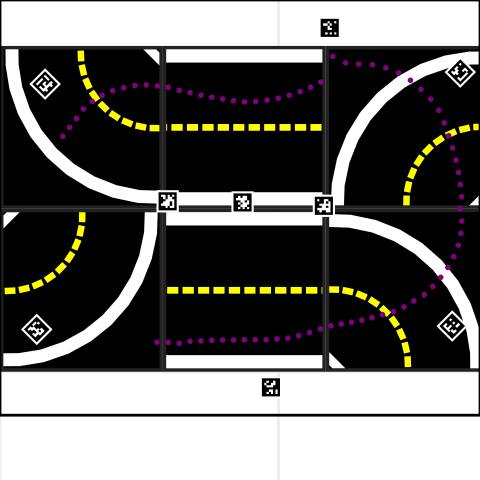

In [37]:

# roughly the number of times the DB went around the loop:
circul = nb_complete_laps + 1
length_loop = (np.asarray(center_line_global).shape[0])
center_line_global_test = [0.0] * length_loop * circul
for i in range(0,circul):
    
    center_line_global_test[i * length_loop:(i+1) * length_loop] = center_line_global
    
# Compute the interpolated trajectories
int_trajs = get_interpolated_points(center_line_global_test, all_trajectories)

# Compute the transforms of those trajectories for plotting
all_int_tfs = []
for traj in int_trajs:
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_int_tfs.append(int_tfs_traj)

# Finally, compute the statistics on the resampled trajectory
# Gets the offset as well as the heading angle based on the interpolated trajectory
mean_tfs, std_y, std_angle, start_idx, end_idx = get_trajectories_statistics(all_int_tfs,center_line_global_tfs)

# print(mean_tfs)
#print(std_y)
# Load the plotting map, this can be different than the previous map (for example, if you don't want apriltags
# in the final plot.)
del m
m = dw.load_map('linus_loop')

# Create objects for drawing
for i, meant_tf in enumerate(mean_tfs):
    if not(i%2):
        m.set_object(str(i + 10000), Circle(0.01, color='purple'), ground_truth=meant_tf)
for i, meant_tf in enumerate(mean_tfs):
    m.set_object(str(i + 1000), AFakeBar(len=std_y[i], color='green'), ground_truth=meant_tf)

# Draw!
outdir = path.join('/home/linuslingg/out', "ipython_draw_svg", "%s" % id(m))

ipython_draw_svg(m);
    

In [38]:
last = -1
dif_offset = []
dif_theta = []
dif_offset_true = []
dif_theta_true = []

time_wt_ar = np.asarray(time_wt)
time_db_ar = np.asarray(time_db)
time_wt_ar_fl = time_wt_ar.astype(float)
time_db_ar_fl = time_db_ar.astype(float)

angle_wt_interp_ar = np.asarray(angle_wt_interp)
angle_db_ar = np.asarray(angle_db)
angle_wt_interp_ar_fl = angle_wt_interp_ar.astype(float)
angle_db_ar_fl = angle_db_ar.astype(float)
# angle_wt_mine_1_ar = np.asarray(angle_wt_mine_1)
# angle_wt_mine_1_ar_fl = angle_wt_mine_1_ar.astype(float)
angle_wt_non_interp_ar = np.asarray(angle_wt_non_interp)
angle_wt_non_interp_ar_fl = angle_wt_non_interp_ar.astype(float)

offset_wt_interp_ar = np.asarray(offset_wt_interp)
offset_db_ar = np.asarray(offset_db)
offset_wt_interp_ar_fl = offset_wt_interp_ar.astype(float)
offset_db_ar_fl = offset_db_ar.astype(float)
# offset_wt_mine_1_ar = np.asarray(offset_wt_mine_1)
# offset_wt_mine_1_ar_fl = offset_wt_mine_1_ar.astype(float)
offset_wt_non_interp_ar = np.asarray(offset_wt_non_interp)
offset_wt_non_interp_ar_fl = offset_wt_non_interp_ar.astype(float)

if recorded_db_bag:
    time_rel_db_ar = np.asarray(time_rel_db)
    d_rel_db_ar = np.asarray(d_rel_db)
    phi_rel_db_ar = np.asarray(phi_rel_db)
    time_rel_db_ar_fl = time_rel_db_ar.astype(float)
    d_rel_db_ar_fl = d_rel_db_ar.astype(float)
    phi_rel_db_ar_fl = phi_rel_db_ar.astype(float)

if recorded_db_bag:   
    for i in range(0,len(time_wt_ar_fl)):
        idx = (find_nearest(time_rel_db_ar_fl, time_wt_ar_fl[i]))
        if time_rel_db_ar_fl[idx] != last:
            
#             dif_offset.append(np.abs(offset_wt_interp_ar_fl[i] - d_rel_db_ar_fl[idx]))
#             dif_theta.append(np.abs(angle_wt_interp_ar_fl[i] - phi_rel_db_ar_fl[idx]))
            
            dif_offset.append(np.abs(offset_wt_non_interp_ar_fl[i] - d_rel_db_ar_fl[idx]))
            dif_theta.append(np.abs(angle_wt_non_interp_ar_fl[i] - phi_rel_db_ar_fl[idx]))
        last = time_rel_db_ar_fl[idx]
else:
    for i in range(0,len(time_wt_ar_fl)):
        idx = (find_nearest(time_db_ar_fl, time_wt_ar_fl[i]))
        if time_db_ar_fl[idx] != last:
            
#             dif_offset.append(np.abs(offset_wt_interp_ar_fl[i] - offset_db_ar_fl[idx]))
#             dif_theta.append(np.abs(angle_wt_interp_ar_fl[i] - angle_db_ar_fl[idx]))
            
            dif_offset.append(np.abs(offset_wt_non_interp_ar_fl[i] - offset_db_ar_fl[idx]))
            dif_theta.append(np.abs(angle_wt_non_interp_ar_fl[i] - angle_db_ar_fl[idx]))
        last = time_db_ar_fl[idx]


## Save data
If you care about the statistics, you can save the data to some directory. You can find the `svg` drawings in the `out/` directory.

In [40]:
# Save everything, just in case
# Save map as yaml file
outdir = path.join(experiment_dir, 'out')
outmap = path.join(outdir, 'out_test.yaml')
benchmark_result = path.join(experiment_dir, 'out/' + name + '_benchmark_results_test_' + test_run + '.yaml')

tpt = actual_length[0]/total_nb_of_tiles

if not recorded_db_bag:
    phi_rel_db = 'Not available'
    time_rel_db = 'Not available'
    d_rel_db = 'Not available'
    phi_rel_db = 'Not available'

# as mean of angle take: stats.circmean(headings, low=-math.pi, high=math.pi)

results = dict(
            Benchmark_Type = 'Lane Following',
            Results = dict(
                Number_of_completed_laps = nb_complete_laps,
                Number_of_tiles_covered = total_nb_of_tiles,
                Avg_time_needed_per_tile = tpt,
                Time_needed_per_straight_tile_sec = 'ToDo',
                Time_needed_per_curved_tile = 'ToDo',
                Theoretical_length_of_benchmark = theoretical_length,
                Length_of_recorded_bag = total_length_bag[0],
                Actual_length_of_benchmark = actual_length[0],
                Tolerance_out_of_sight = tolerance_out_of_sight,
                Out_of_sight = out_of_sight,
                Time_out_of_sight = time_lasted[0],
                Tolerance_too_slow_sec = max_time_on_tile,
                Too_slow = too_slow,
                Time_too_slow = time_lasted_slow[0],
                Position_too_slow = 'ToDo',
                Abs_Ground_truth_wt_mean_offset_non_interp = float(np.round(np.mean(abs(offset_wt_non_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_mean_angle_non_interp = float(np.round(math.degrees(stats.circmean(abs(angle_wt_non_interp_ar_fl), low=-math.pi, high=math.pi)),4)),
                Abs_Ground_truth_wt_median_offset_non_interp = float(np.round(np.median(abs(offset_wt_non_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_median_angle_non_interp = float(np.round(math.degrees(np.median(abs(angle_wt_non_interp_ar_fl))),4)),
                Abs_Ground_truth_wt_std_offset_non_interp = float(np.round(np.std(abs(offset_wt_non_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_std_angle_non_interp = float(np.round(math.degrees(stats.circstd(abs(angle_wt_non_interp_ar_fl), low=-math.pi, high=math.pi)),4)),
                Abs_Ground_truth_wt_mean_offset_interp = float(np.round(np.mean(abs(offset_wt_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_mean_angle_interp = float(np.round(math.degrees(stats.circmean(abs(angle_wt_interp_ar_fl), low=-math.pi, high=math.pi)),4)),
                Abs_Ground_truth_wt_median_offset_interp = float(np.round(np.median(abs(offset_wt_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_median_angle_interp = float(np.round(math.degrees(np.median(abs(angle_wt_interp_ar_fl))),4)),
                Abs_Ground_truth_wt_std_offset_interp = float(np.round(np.std(abs(offset_wt_interp_ar_fl)),4)),
                Abs_Ground_truth_wt_std_angle_interp = float(np.round(math.degrees(stats.circstd(abs(angle_wt_interp_ar_fl), low=-math.pi, high=math.pi)),4)),
                Abs_Measurements_db_std_offset = float(np.round(np.std(abs(offset_db_ar_fl)),4)),
                Abs_Measurements_db_std_angle = float(np.round(math.degrees(np.std(abs(angle_db_ar_fl))),4)),
                Abs_Measurements_db_mean_offset = float(np.round(np.mean(abs(offset_db_ar_fl)),4)),
                Abs_Measurements_db_mean_angle = float(np.round(math.degrees(np.mean(abs(angle_db_ar_fl))),4)),
                Abs_Measurements_db_median_offset = float(np.round(np.median(abs(offset_db_ar_fl)),4)),
                Abs_Measurements_db_median_angle = float(np.round(math.degrees(np.median(abs(angle_db_ar_fl))))),
                std_diff_btw_estimation_and_ground_truth_offset = float(np.round(np.std(dif_offset),4)),
                std_diff_btw_estimation_and_ground_truth_angle = float(np.round(math.degrees(stats.circstd(dif_theta, low=-math.pi, high=math.pi)),4)),
                mean_diff_btw_estimation_and_ground_truth_offset = float(np.round(np.mean(dif_offset),4)),
                mean_diff_btw_estimation_and_ground_truth_angle = float(np.round(math.degrees(stats.circmean(dif_theta, low=-math.pi, high=math.pi)),4)),
                median_diff_btw_estimation_and_ground_truth_offset = float(np.round(np.median(dif_offset),4)),
                median_diff_btw_estimation_and_ground_truth_angle = float(np.round(math.degrees(np.median(dif_theta)),4)),
                angle_wt_interp = angle_wt,
                angle_db = angle_db,
                angle_wt_non_interp = angle_wt_non_interp, 
                angle_db_true = phi_rel_db,
                offset_wt_interp= offset_wt,
                offset_db = offset_db,
                offset_wt_non_interp = offset_wt_non_interp,
                offset_db_true = d_rel_db,
                time_wt = time_wt,
                time_db = time_db,
                time_db_true = time_rel_db,
                all_trajectories = all_traj_save,
                all_trajectories_db = all_traj_db_save,
                int_trajs = int_trajs_save,
                begin_time_stamp_wt = begin_time_stamp_wt
                )
            )


with open(benchmark_result, 'w') as yaml_file:
    yaml.dump(results, yaml_file, default_flow_style=False)

